In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from IPython.display import clear_output
!pip install imutils
!pip install umap-learn
clear_output()

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import cv2
import math
import umap
import keras
import shutil
import random
import imutils
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import plotly.graph_objs as go
import matplotlib.pyplot as plt




from tqdm import tqdm
from PIL import Image
from os import listdir
from scipy import misc
from keras import layers
from plotly import tools
from random import shuffle
from itertools import chain
from numpy import expand_dims
from matplotlib import pyplot 
from keras import backend as K
from keras.layers import Input
from collections import Counter
from os.path import isfile, join
from sklearn.manifold import TSNE
from skimage.transform import resize
from skimage.morphology import label
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from IPython.display import clear_output
from sklearn.metrics import recall_score
from sklearn.datasets import make_circles
from sklearn.metrics import roc_auc_score
from keras.layers.merge import concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.metrics import precision_score
from keras.layers.core import Dropout, Lambda
from sklearn.metrics import cohen_kappa_score
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import load_img
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from plotly.offline import init_notebook_mode, iplot
from keras.models import Model, Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.vgg19 import VGG19, preprocess_input
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from skimage.io import imread, imshow, imread_collection, concatenate_images


init_notebook_mode(connected=True)
RANDOM_SEED = 1998

In [4]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── drive
│   └── MyDrive
│       ├── Act assignment 2
│       ├── archive
│       │   ├── no
│       │   ├── pred
│       │   └── yes
│       ├── Classroom
│       │   ├── CSE 345 Section 3
│       │   ├── CSE350 3
│       │   ├── Jaj Jsjs
│       │   └── KMHB FALL 19 2,3,4
│       ├── Colab Notebooks
│       ├── pass
│       └── pwp
├── sample_data
├── TEST
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

25 directories


In [5]:
IMG_PATH = '/content/drive/MyDrive/archive/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if (not CLASS.startswith('.') and (not CLASS.startswith('pred'))):
        print(IMG_PATH + '     ' + CLASS)
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 200:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 1200:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

/content/drive/MyDrive/archive/     no
/content/drive/MyDrive/archive/     yes


In [7]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [8]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:05<00:00,  2.53s/it]


2000 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


400 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

600 images loaded from VAL/ directory.


In [9]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#4A235A'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#cc2900'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data,layout)
fig.show(renderer="colab")

In [10]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

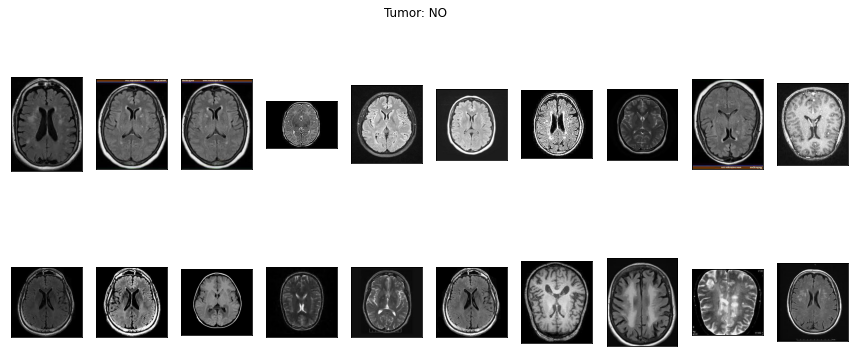

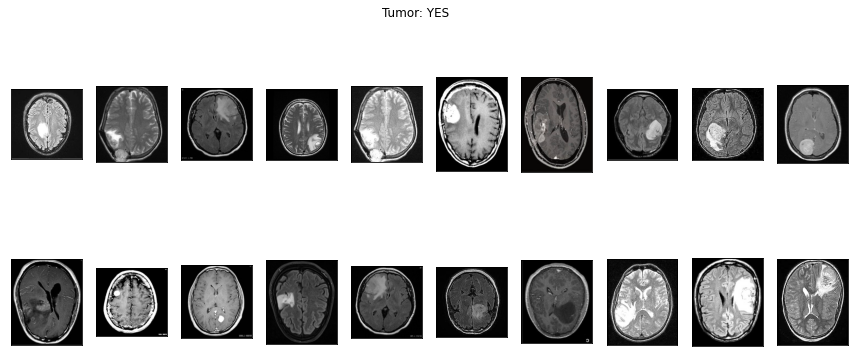

In [11]:
plot_samples(X_train, y_train, labels, 20)

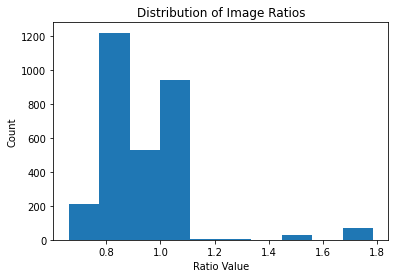

In [12]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [13]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)
    return np.array(set_new)

In [14]:
img = cv2.imread('/content/drive/MyDrive/archive/yes/y54.jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

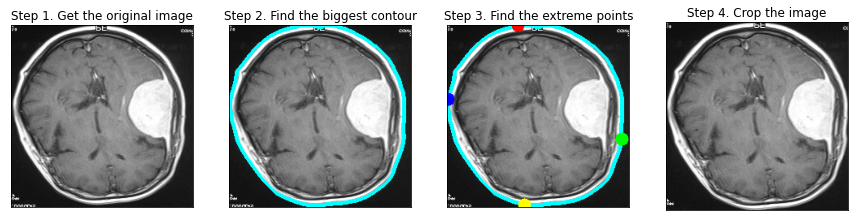

In [15]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [16]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

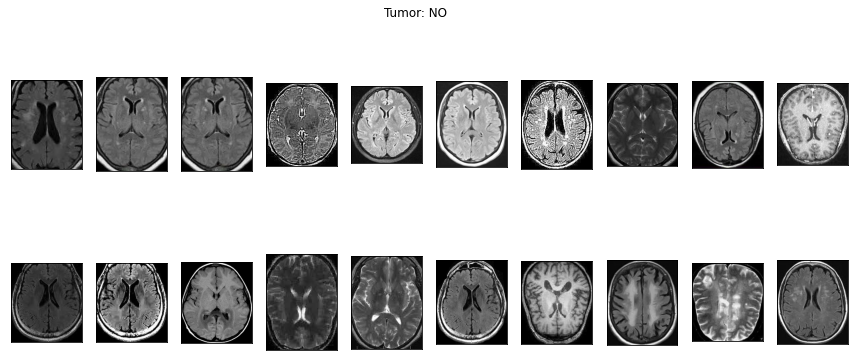

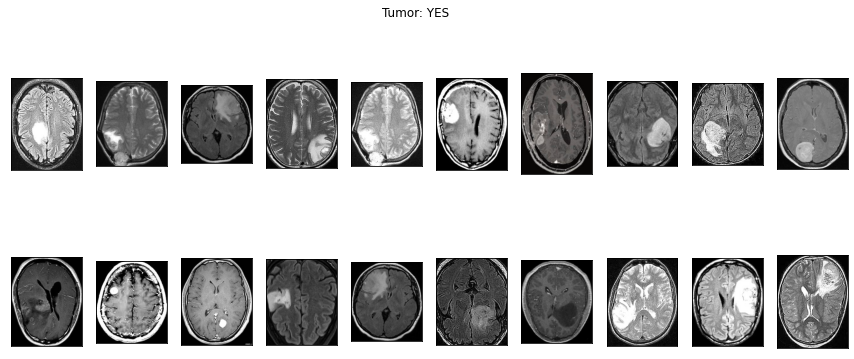

In [17]:
plot_samples(X_train_crop, y_train, labels, 20)

In [18]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [19]:
# saving new images to the folder
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [20]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-16 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [21]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

## CNN Model

### Data Augmentation

In [22]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [23]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

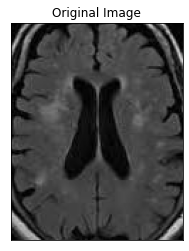

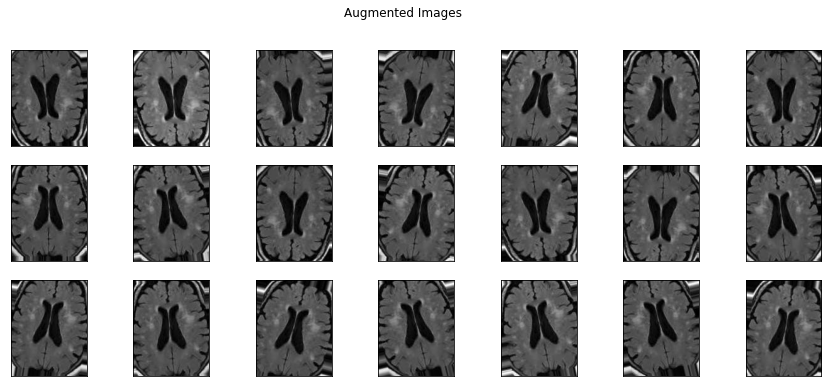

In [24]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augmented Images')
plt.show()

### Application

In [25]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 2000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


## Model Creation

### VGG 16

In [26]:
from keras.applications.vgg16 import VGG16

In [27]:
# load base model
vgg = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

58900480/58889256 [==============================] - 1s 0us/step


In [28]:
import tensorflow as tf
from tensorflow import keras

In [29]:
NUM_CLASSES = 1

vgg16 = Sequential()
vgg16.add(vgg)
vgg16.add(layers.Flatten())
vgg16.add(layers.Dropout(0.2))
vgg16.add(layers.Dense(1024, activation='relu'))
vgg16.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

vgg16.layers[0].trainable = False


vgg16.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])

vgg16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 40,406,849
Trainable params: 25,692,161
Non-trainable params: 14,714,688
_________________________________________________________________


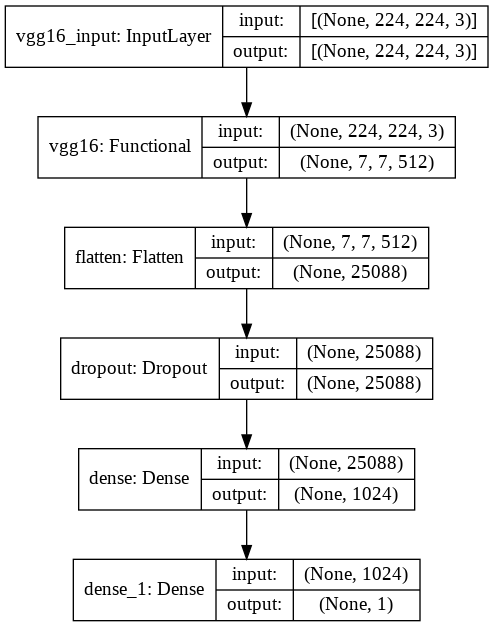

In [30]:
tf.keras.utils.plot_model(vgg16, show_shapes=True)

In [31]:
EPOCHS = 20


import time
start = time.time()

vgg16_history = vgg16.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=30,
)

end = time.time()
print(end - start)

Epoch 1/20
50/50 [==============================] - 947s 19s/step - loss: 1.0470 - accuracy: 0.6950 - val_loss: 0.2740 - val_accuracy: 0.8896
Epoch 2/20
50/50 [==============================] - 939s 19s/step - loss: 0.2718 - accuracy: 0.8870 - val_loss: 0.2441 - val_accuracy: 0.9125
Epoch 3/20
50/50 [==============================] - 947s 19s/step - loss: 0.2437 - accuracy: 0.8990 - val_loss: 0.3480 - val_accuracy: 0.8562
Epoch 4/20
50/50 [==============================] - 960s 19s/step - loss: 0.2101 - accuracy: 0.9162 - val_loss: 0.1486 - val_accuracy: 0.9438
Epoch 5/20
50/50 [==============================] - 953s 19s/step - loss: 0.1494 - accuracy: 0.9394 - val_loss: 0.1516 - val_accuracy: 0.9312
Epoch 6/20
50/50 [==============================] - 947s 19s/step - loss: 0.1438 - accuracy: 0.9444 - val_loss: 0.0877 - val_accuracy: 0.9729
Epoch 7/20
50/50 [==============================] - 948s 19s/step - loss: 0.1131 - accuracy: 0.9539 - val_loss: 0.1017 - val_accuracy: 0.9604
Epoch 

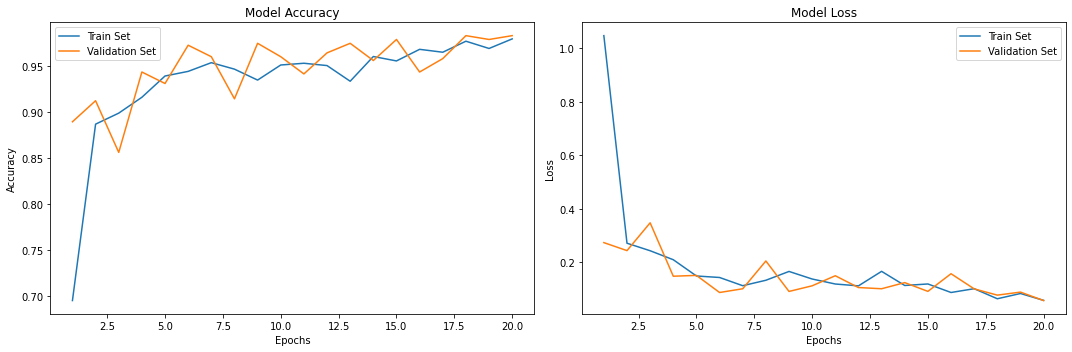

In [32]:
# plot model performance
acc = vgg16_history.history['accuracy']
val_acc = vgg16_history.history['val_accuracy']
loss = vgg16_history.history['loss']
val_loss = vgg16_history.history['val_loss']
epochs_range = range(1, len(vgg16_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.97


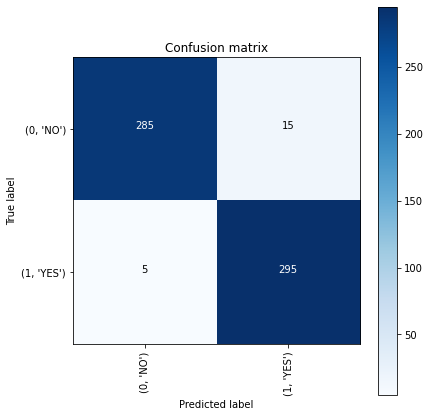

In [33]:
# validate on val set
predictions = vgg16.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [34]:
#for validation set(vgg16)

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score




accuracy = accuracy_score(y_val, predictions)
print('Accuracy: %.2f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %.2f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %.2f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %.2f' % f1)

Accuracy: 0.97
Precision: 0.95
Recall: 0.98
F1 score: 0.97


Test Accuracy = 0.96


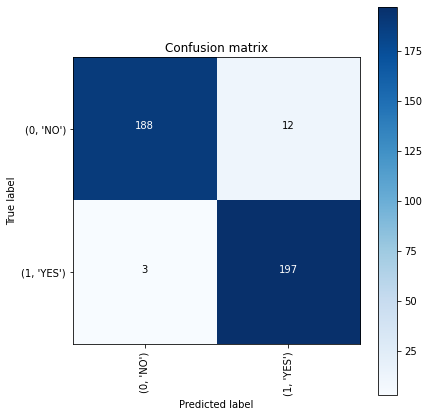

In [35]:
# validate on test set
predictions = vgg16.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [37]:
#for test set(vgg16)

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.2f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %.2f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %.2f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %.2f' % f1)

Accuracy: 0.96
Precision: 0.94
Recall: 0.98
F1 score: 0.96


## VGG 19

In [ ]:
from keras.applications.vgg19 import VGG19

In [ ]:
# load base model
vgg = VGG19(
    weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
NUM_CLASSES = 1

vgg19 = Sequential()
vgg19.add(vgg)
vgg19.add(layers.Flatten())
vgg19.add(layers.Dropout(0.2))
vgg19.add(layers.Dense(1024, activation='relu'))
vgg19.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

vgg19.layers[0].trainable = False


vgg19.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])

vgg19.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 45,716,545
Trainable params: 25,692,161
Non-trainable params: 20,024,384
_________________________________________________________________


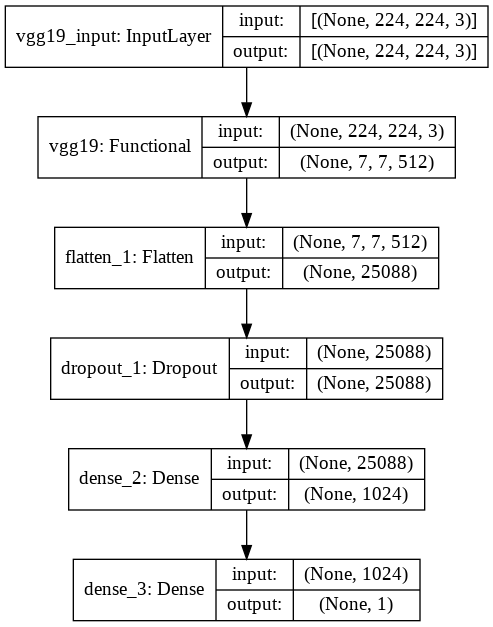

In [ ]:
tf.keras.utils.plot_model(vgg19, show_shapes=True)

In [ ]:
EPOCHS = 20


import time
start = time.time()

vgg19_history = vgg19.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=30,
  
)

end = time.time()
print(end - start)

Epoch 1/20
50/50 [==============================] - 1313s 26s/step - loss: 0.7928 - accuracy: 0.7551 - val_loss: 0.2744 - val_accuracy: 0.8854
Epoch 2/20
50/50 [==============================] - 1313s 26s/step - loss: 0.2606 - accuracy: 0.8939 - val_loss: 0.3308 - val_accuracy: 0.8583
Epoch 3/20
50/50 [==============================] - 1324s 27s/step - loss: 0.2509 - accuracy: 0.8925 - val_loss: 0.2984 - val_accuracy: 0.8729
Epoch 4/20
50/50 [==============================] - 1319s 26s/step - loss: 0.2070 - accuracy: 0.9141 - val_loss: 0.1787 - val_accuracy: 0.9312
Epoch 5/20
50/50 [==============================] - 1318s 26s/step - loss: 0.2167 - accuracy: 0.9160 - val_loss: 0.1547 - val_accuracy: 0.9333
Epoch 6/20
50/50 [==============================] - 1312s 27s/step - loss: 0.1572 - accuracy: 0.9362 - val_loss: 0.1194 - val_accuracy: 0.9521
Epoch 7/20
50/50 [==============================] - 1320s 27s/step - loss: 0.1387 - accuracy: 0.9438 - val_loss: 0.1232 - val_accuracy: 0.9625

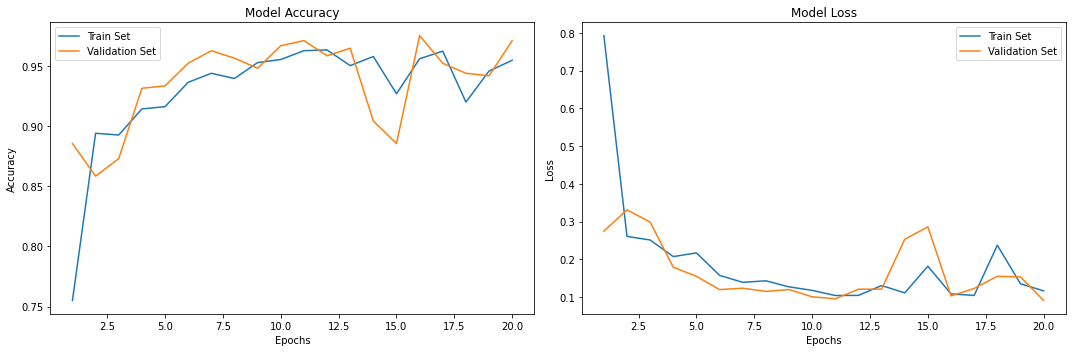

In [ ]:
# plot model performance
acc = vgg19_history.history['accuracy']
val_acc = vgg19_history.history['val_accuracy']
loss = vgg19_history.history['loss']
val_loss = vgg19_history.history['val_loss']
epochs_range = range(1, len(vgg19_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.97


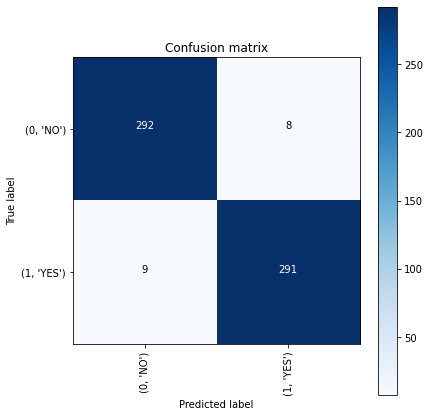

In [ ]:
# validate on val set
predictions = vgg19.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
#for validation set(vgg19)

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score



accuracy = accuracy_score(y_val, predictions)
print('Accuracy: %.2f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %.2f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %.2f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %.2f' % f1)

Accuracy: 0.97
Precision: 0.97
Recall: 0.97
F1 score: 0.97


Test Accuracy = 0.96


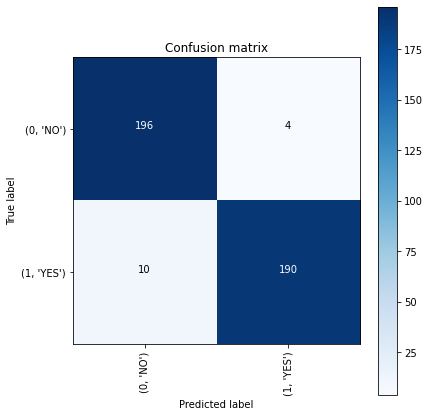

In [ ]:
# validate on test set(vgg19)
predictions = vgg19.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
#for test set(vgg19)

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.2f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %.2f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %.2f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %.2f' % f1)

Accuracy: 0.96
Precision: 0.98
Recall: 0.95
F1 score: 0.96


## Inception V3

In [ ]:
from keras.applications.inception_v3 import InceptionV3

In [ ]:
# load base model
inceptionV3 = InceptionV3(
     weights='imagenet',
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
NUM_CLASSES = 1

inception_v3 = Sequential()
inception_v3.add(inceptionV3)
inception_v3.add(layers.Flatten())
inception_v3.add(layers.Dropout(0.2))
inception_v3.add(layers.Dense(1024, activation='relu'))
inception_v3.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

inception_v3.layers[0].trainable = False


inception_v3.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), metrics=["accuracy"])

inception_v3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dropout (Dropout)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              52429824  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 74,233,633
Trainable params: 52,430,849
Non-trainable params: 21,802,784
_________________________________________________________________


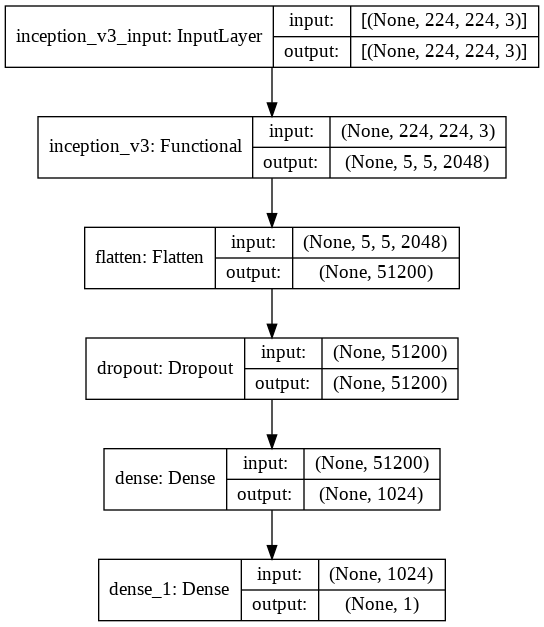

In [ ]:
tf.keras.utils.plot_model(inception_v3, show_shapes=True)

In [ ]:
EPOCHS = 20


import time
start = time.time()

inception_v3_history = inception_v3.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=30
)

end = time.time()
print(end - start)

Epoch 1/20
50/50 [==============================] - 253s 5s/step - loss: 2.5828 - accuracy: 0.7700 - val_loss: 0.4133 - val_accuracy: 0.9125
Epoch 2/20
50/50 [==============================] - 244s 5s/step - loss: 0.6414 - accuracy: 0.8718 - val_loss: 0.3851 - val_accuracy: 0.9187
Epoch 3/20
50/50 [==============================] - 245s 5s/step - loss: 0.5564 - accuracy: 0.8800 - val_loss: 1.3288 - val_accuracy: 0.7563
Epoch 4/20
50/50 [==============================] - 245s 5s/step - loss: 0.5621 - accuracy: 0.8914 - val_loss: 0.3527 - val_accuracy: 0.9208
Epoch 5/20
50/50 [==============================] - 245s 5s/step - loss: 0.7509 - accuracy: 0.8699 - val_loss: 0.7172 - val_accuracy: 0.8854
Epoch 6/20
50/50 [==============================] - 244s 5s/step - loss: 0.5481 - accuracy: 0.8920 - val_loss: 0.3484 - val_accuracy: 0.9021
Epoch 7/20
50/50 [==============================] - 245s 5s/step - loss: 0.4522 - accuracy: 0.9034 - val_loss: 0.1857 - val_accuracy: 0.9417
Epoch 8/20
50

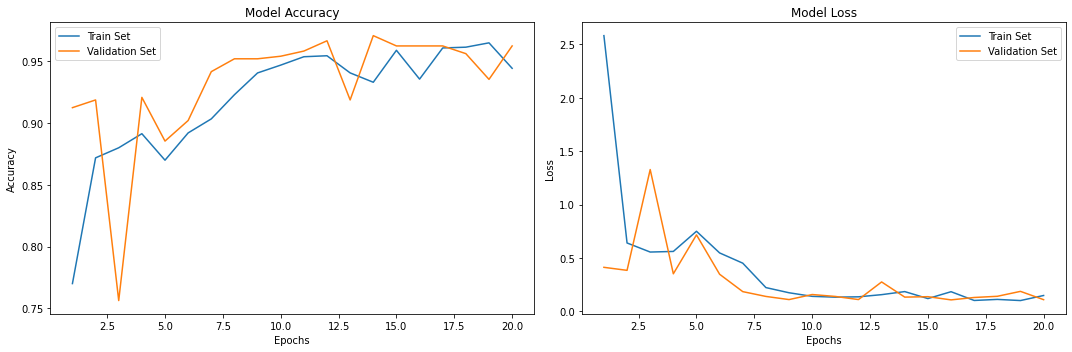

In [ ]:
# plot model performance
acc = inception_v3_history.history['accuracy']
val_acc = inception_v3_history.history['val_accuracy']
loss = inception_v3_history.history['loss']
val_loss = inception_v3_history.history['val_loss']
epochs_range = range(1, len(inception_v3_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

Val Accuracy = 0.96


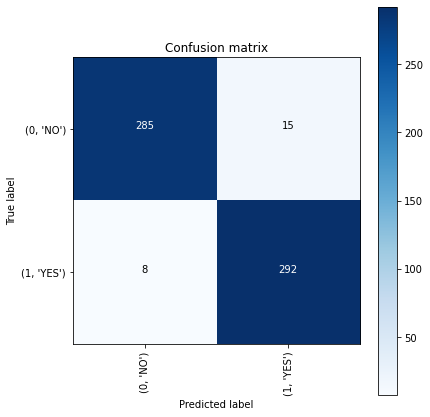

In [ ]:
# validate on val set
predictions = inception_v3.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
#for validation set(inception v3)

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score



accuracy = accuracy_score(y_val, predictions)
print('Accuracy: %.2f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_val, predictions)
print('Precision: %.2f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_val, predictions)
print('Recall: %.2f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_val, predictions)
print('F1 score: %.2f' % f1)

Accuracy: 0.96
Precision: 0.95
Recall: 0.97
F1 score: 0.96


Test Accuracy = 0.96


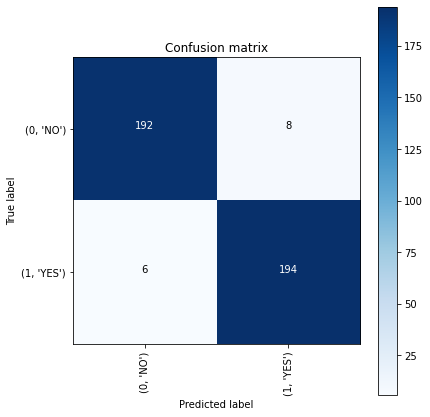

In [ ]:
# validate on test set(inception v3)
predictions = inception_v3.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

In [ ]:
#for test set(inception v3)

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, predictions)
print('Accuracy: %.2f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, predictions)
print('Precision: %.2f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, predictions)
print('Recall: %.2f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, predictions)
print('F1 score: %.2f' % f1)

Accuracy: 0.96
Precision: 0.96
Recall: 0.97
F1 score: 0.97
